In [1]:
#load libraries
import math
import numpy as np
import warnings
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.ndimage import zoom
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import interpolate
from functools import partial
from scipy.stats import norm
import ipympl
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import cumulative_trapezoid
import time
from scipy.optimize import minimize
def load_object(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)
%matplotlib widget

# UTILITY

In [2]:
def make_nss_yield_df(start_date='1986-12-01', end_date='2025-03-01', max_maturity=120):
    df = pd.read_csv('../feds200628.csv', skiprows=9)
    df = df[['Date', 'BETA0', 'BETA1', 'BETA2', 'BETA3', 'TAU1', 'TAU2']]
    df['Date'] = pd.to_datetime(df['Date'])#.dt.date
    
    n_years = np.arange(0,max_maturity) / 12
    yields = np.empty((len(df), len(n_years)))
    for i, n in enumerate(n_years):
        tau1, tau2 = df['TAU1'], df['TAU2']
        term1 = (1 - np.exp(-n / tau1)) / (n / tau1)
        term2 = np.exp(-n / tau1)
        term3 = (1 - np.exp(-n / tau2)) / (n / tau2)
        term4 = np.exp(-n / tau2)
        yields[:, i] = df['BETA0'] + df['BETA1'] * term1 + df['BETA2'] * (term1 - term2) + df['BETA3'] * (term3 - term4)

    yield_cols = [f'{int(m*12)}m' for m in n_years]
    yields_df = pd.DataFrame(yields, columns=yield_cols, index=df['Date'])
    yields_df = yields_df[start_date:end_date]#.dropna()#.resample('BME').last().to_period('M')
    return yields_df / 100

def compute_6m_forward_curve(yields_df, tau=0.5):
    maturities = np.array([int(col.strip('m')) for col in yields_df.columns]) / 12
    fwd_df = pd.DataFrame(index=yields_df.index, columns=yields_df.columns[:-6])
    tau_in_months = int(tau * 12)
    for i, T in enumerate(maturities[:-6]):
        y_T = yields_df.iloc[:, i]
        y_Tp = yields_df.iloc[:, i + 6]
        P_T = np.exp(-T * y_T)
        P_Tp = np.exp(-(T + 0.5) * y_Tp)
        fwd_df.iloc[:, i] = (P_T / P_Tp - 1) / 0.5

    return fwd_df.astype(float)







def estimate_X_full_PCA(df_forwards, n_components=5):
    # Optionally skip short end
    #X_maturities_idx = np.arange(3, df_forwards.shape[1])  # skip first 3
    pca_data = df_forwards#.iloc[:, X_maturities_idx]
    
    scaler = StandardScaler()
    pca_data_scaled = scaler.fit_transform(pca_data)

    pca = PCA(n_components=n_components, whiten=False)
    X_full = pca.fit_transform(pca_data_scaled)

    df_pcs = pd.DataFrame(X_full, index=df_forwards.index, columns=[f"PC{i+1}" for i in range(n_components)])
    return df_pcs, pca, scaler


def tag_regime_and_stress(date):
    if isinstance(date, pd.Period):
        date = date.to_timestamp()

    if date < pd.Timestamp('1987-08-11'):
        return 'Volcker', 3
    elif date < pd.Timestamp('1995-06-01'):
        return 'Greenspan I', 1
    elif date < pd.Timestamp('2001-01-01'):
        return 'Greenspan II', 0
    elif date < pd.Timestamp('2004-06-01'):
        return 'Post-dotcom easing', 1
    elif date < pd.Timestamp('2007-07-01'):
        return 'Pre-GFC tightening', 1
    elif date < pd.Timestamp('2010-01-01'):
        return 'GFC', 4
    elif date < pd.Timestamp('2016-01-01'):
        return 'ZIRP/QE1-3', 0
    elif date < pd.Timestamp('2020-01-01'):
        return 'Normalization', 1
    elif date < pd.Timestamp('2020-06-01'):
        return 'COVID crash', 4
    elif date < pd.Timestamp('2022-03-01'):
        return 'Pandemic QE', 0
    else:
        return 'QT/Inflation', 2.5

#forwards_data[['regime', 'stress']] = forwards_data.index.to_series().apply(lambda d: pd.Series(tag_regime_and_stress(d)))


def compute_6m_forward_dataframe(yields_df, tau=0.5):
    """
    Compute a DataFrame of 6M simple-compounded forward rates with tau-spaced columns.
    Assumes yield curve starts at time 0 and is monthly spaced.

    Parameters
    ----------
    yields_df : pd.DataFrame
        DataFrame of continuous-compounded yields (decimal format), starting at 0m with 1M spacing.
        
    tau : float
        Forward tenor in years (default 0.5 for 6M).
        
    Returns
    -------
    df_fwd : pd.DataFrame
        DataFrame of 6M forward rates with columns tau-spaced (e.g., '0m', '6m', '12m', ...)
    """
    tau_in_months = int(tau * 12)
    total_months = len(yields_df.columns)
    maturities = np.arange(total_months) / 12  # 0m to (n-1)m in years

    # Choose columns spaced every tau months starting from 0
    fwd_col_indices = np.arange(0, total_months - tau_in_months, tau_in_months)
    fwd_col_names = [f"{i}m" for i in fwd_col_indices]

    df_fwd = pd.DataFrame(index=yields_df.index, columns=fwd_col_names)

    # Extract necessary slices
    T = maturities[fwd_col_indices].reshape(1, -1)
    y_T = yields_df.iloc[:, fwd_col_indices].values
    y_Tp = yields_df.iloc[:, fwd_col_indices + tau_in_months].values

    P_T = np.exp(-T * y_T)
    P_Tp = np.exp(-(T + tau) * y_Tp)

    fwd = (P_T / P_Tp - 1) / tau
    df_fwd.loc[:, :] = fwd
    if "0m" in df_fwd.columns:
        df_fwd["0m"] = yields_df.iloc[:, tau_in_months]  # spot 6M yield (continuous)
        df_fwd["0m"] = (np.exp(tau * df_fwd["0m"]) - 1) / tau  # convert to simple-compounded
    df_fwd = df_fwd.dropna().astype(float)
    df_fwd[['regime', 'stress']] = df_fwd.index.to_series().apply(lambda d: pd.Series(tag_regime_and_stress(d)))
    return df_fwd


def sample_forward_curves(forwards_df, regime=None, stress=None, n=100):
    """
    Sample forward curves from historical data with optional filtering on regime or stress.

    Parameters:
    - forwards_df: DataFrame with columns [fwd1, fwd2, ..., regime, stress]
    - regime: optional string or list of regimes to filter on
    - stress: optional numeric (or list of values) to filter on
    - n: number of samples to draw

    Returns:
    - np.ndarray of shape (n, #forwards)
    """
    df = forwards_df.copy()

    if regime is not None:
        if isinstance(regime, str):
            regime = [regime]
        df = df[df['regime'].isin(regime)]

    if stress is not None:
        if isinstance(stress, (int, float)):
            stress = [stress]
        df = df[df['stress'].isin(stress)]

    if len(df) == 0:
        raise ValueError("No data matches the specified regime/stress filter.")

    idx = df.sample(n=n, replace=True).index
    return df.loc[idx, df.columns[:-2]].values  # exclude regime and stress



def project_to_feasible_scipy(z0, components, mean, scaler, tol=1e-6):
    """
    Project latent vector z0 to feasible region where
    scaler.inverse_transform(mean + components.T @ z) >= 0 (elementwise)
    
    Parameters:
    - z0: Initial PCA sample (shape [n_components])
    - components: PCA components (n_components, n_features)
    - mean: PCA mean (in scaled space)
    - scaler: StandardScaler used to normalize the data
    """
    def objective(z):
        return np.sum((z - z0)**2)

    def constraint_func(z):
        x_scaled = mean + components.T @ z  # z is [n_components], x_scaled is [n_features]
        x_raw = scaler.inverse_transform(x_scaled.reshape(1, -1))[0]
        return x_raw  # must be >= 0 elementwise

    constraints = {
        'type': 'ineq',
        'fun': constraint_func
    }

    res = minimize(
        objective,
        z0,
        constraints=constraints,
        method='SLSQP',
        options={'ftol': 1e-9, 'disp': False, 'maxiter': 500}
    )

    if res.success and np.all(constraint_func(res.x) >= -tol):
        return res.x
    else:
        return None



# def sample_feasible_curves(pca_obj, scaler, n_samples=100):
#     components = pca_obj.components_
#     mean = pca_obj.mean_
#     variances = pca_obj.explained_variance_
#     n_components = components.shape[0]

#     curves = []
#     iterator = 0
#     while len(curves) < n_samples:
#         z0 = np.random.randn(n_components) * np.sqrt(variances)
#         z_feasible = project_to_feasible_scipy(z0, components, mean,scaler)
#         if z_feasible is not None:
#             X_scaled = z_feasible @ components
#             curve = scaler.inverse_transform(X_scaled.reshape(1, -1))[0]

#             curves.append(curve)
#         iterator += 1
#     print(f"Generated {len(curves)} curves in {iterator} iterations.")
#     return np.vstack(curves)


df_fwd = compute_6m_forward_dataframe(make_nss_yield_df())
random_samples = sample_forward_curves(df_fwd, n=5)

print(len(df_fwd))

9549


[[0.00169266 0.00147985 0.00235736 0.00402536 0.00624291 0.00881755
  0.01159692 0.01446172 0.0173199  0.02010184 0.02275626 0.02524683
  0.02754927 0.02964902 0.03153916 0.03321879 0.03469161 0.03596479
  0.03704803]
 [0.00185553 0.00200621 0.00419858 0.00759783 0.01162259 0.01587528
  0.02009141 0.02410229 0.02780751 0.03115463 0.03412425 0.03671904
  0.03895585 0.04086002 0.0424614  0.04379154 0.04488189 0.04576257
  0.04646168]
 [0.06733464 0.07705259 0.08224257 0.08550184 0.08787862 0.08976654
  0.09130696 0.09255718 0.09355356 0.09433064 0.09492403 0.09536852
  0.09569585 0.09593332 0.09610336 0.09622373 0.09630808 0.09636666
  0.09640703]
 [0.05294259 0.04727319 0.04355922 0.0412506  0.03994616 0.03935292
  0.03925686 0.03950172 0.03997361 0.04058976 0.04129025 0.04203197
  0.04278416 0.04352513 0.04423986 0.04491817 0.04555347 0.04614174
  0.04668084]
 [0.05297719 0.05761703 0.06043195 0.0620944  0.06306987 0.0636727
  0.06410842 0.0645054  0.06493831 0.06544512 0.06603949 0.06

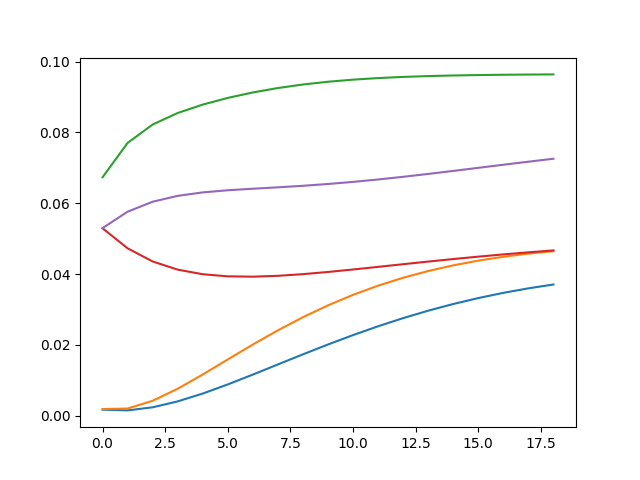

In [3]:
random_samples = sample_forward_curves(df_fwd, n=5)
print(random_samples)
plt.clf()
plt.plot(random_samples.T)
plt.show()

In [ ]:

def doust_corr(beta, n):
    '''
    create nxn doust correlation with beta decay exponential
    n = # of semi-annual expiries
    '''
    tau = np.arange(0, n+1)/2 # start from spot
    a = np.exp(- beta / np.arange(1, len(tau[:-1])+1) )
    doust = np.zeros((n, n))
    dim = doust.shape
    for i in range(doust.shape[0]):
        for j in range(doust.shape[1]):
            if i == j:
                doust[i, j] = 1
            elif i > j:
                doust[i, j] = np.prod(a[j:i])
    #reflect
    doust[np.triu_indices(dim[0], 1)] = doust.T[np.triu_indices(dim[0], 1)]
    return doust


def interpolate_correlation_matrix(matrix: np.ndarray, resolution: int) -> np.ndarray:
    """
    Interpolates a correlation matrix using bilinear interpolation.

    Args:
        matrix (np.ndarray): The input correlation matrix (must be square).
        resolution (int): The resolution factor. For a 4x4 and resolution=2, output will be 7x7.

    Returns:
        np.ndarray: Interpolated correlation matrix.
    """
    if matrix.shape[0] != matrix.shape[1]:
        raise ValueError("Input must be a square matrix.")

    # Compute zoom factor: new_size = original_size + (original_size - 1) * (resolution - 1)
    zoom_factor = resolution

    # Use order=1 for bilinear interpolation
    interpolated = zoom(matrix, zoom=zoom_factor, order=1)

    # Adjust shape to match expected output: new size = original + (n-1)*(res-1)
    target_size = matrix.shape[0] + (matrix.shape[0] - 1) * (resolution - 1)
    interpolated = interpolated[:target_size, :target_size]

    return interpolated



def get_instant_vol_func(tau , params):
    '''
    Return the instantaneous volatility ,
    computed in terms of the parametric
    form proposed by Rebonato , at a given time t.
    @var t: time at which we want to compute the
    instantaneous volatility (in years)
    @var expiry: caplet expiry (in years)
    @var a: parameter a of Rebonato ’s instant. vol. function
    @var b: parameter b of Rebonato ’s instant. vol. function
    @var c: parameter c of Rebonato ’s instant. vol. function
    @var d: parameter d of Rebonato ’s instant. vol. function
    
    #g(T - t) & h(T - t)
    '''
    tau = np.maximum(tau, 0)
    a,b,c,d = params
    instantaneous_vol = (a + b * tau) * np.exp(-c * tau) + d
    return instantaneous_vol






def pairwise_outer(arr):
    """
    Given an array of shape (..., d), return an array of shape (..., d, d),
    where each (...)-indexed vector is expanded to an outer product with itself.

    Parameters:
    - arr: np.ndarray, shape (..., d)

    Returns:
    - out: np.ndarray, shape (..., d, d)
    """
    return arr[..., :, None] * arr[..., None, :]


In [5]:
n = 19
np.linspace(0, n*0.5, int(n/2*2+1))

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
       6.5, 7. , 7.5, 8. , 8.5, 9. , 9.5])

# DATA LOADING AND CLEANING

In [20]:
path_params = os.path.join(os.getcwd(), "parameters")
forwards = load_object(path_params+"/spot_forwards.pkl")
s0_exp = load_object(path_params+"/vol_initial_correction.pkl")
epsilon_exp = load_object(path_params+"/volvol_initial_correction.pkl")
doust_fwd_fwd = load_object(path_params+"/fwdfwd_corr.pkl")
doust_vol_vol = load_object(path_params+"/volvol_corr.pkl")
corr_fwd_vol = load_object(path_params+"/fwdvol_corr.pkl")
params_g = load_object(path_params+"/vol_params_g.pkl")
params_h= load_object(path_params+"/volvol_params_h.pkl")
spots= load_object(path_params+"/spot_rates.pkl")
params_g = np.array([-0.00557585, -0.00864318,  0.89466108,  0.00755986])
params_h = np.array([1.42258187e-08, 3.01935702e01, 4.57201647e00, 4.05843346e-12,])
epsilon_exp = np.concatenate([epsilon_exp[[0]],epsilon_exp])
s0_exp = np.concatenate([s0_exp[[0]], s0_exp])



rho_mat_6m = doust_fwd_fwd[:19, :19]
theta_mat_6m = doust_vol_vol[:19, :19] #TODO: check if this is correct, or it should remove the first row and column instead
phi_mat_diag = corr_fwd_vol
fwd_tenors = np.arange(1,10.5,0.5)
# self defined
params_g = np.array([0.005, 0.04, 1, 0.001])
params_h = np.array([0.001, 3, 3, 0.01])
s0_exp = np.ones_like(s0_exp)


# Create new matrices 


beta_6m = 0.20696204
beta_0m = 0.25697769
beta_theta_0m = 0.1556888
beta_theta_6m = 0.12135651
n=20





# create phi 



# interpolate phi diag
phi_diag = np.diag(corr_fwd_vol)

phi_diag = np.concatenate([phi_diag[[0]],phi_diag])
T_phi = np.arange(0,10, 0.5)

# SHOULD BE IN LMM CLASS

rho_mat_0m = doust_corr(beta_0m, n)
theta_mat_0m = doust_corr(beta_theta_0m, n)
phi_mat_0m = build_phi_matrix(T_phi, phi_diag, 0.0087931, 0.051319)


# create rates 
path = os.path.join(os.getcwd(), "raw_dataset")
df_cap = pd.read_excel(path+"/caplet_raw.xlsx", sheet_name = 2, header = 0)
df_raw_spot = pd.read_csv(path+"/spot.csv")
df_raw_spot["Tenor"] = np.array([1/12, 2/12, 3/12, 0.5, 0.75, 1, 2, 3, 4, 5, 7, 9, 10, 12, 15, 20, 30, 50])


def sample_phi_diag_mvn(T, mean=-0.5, sigma=0.1, beta=0.1, clip_bounds=(-0.9, -0.3)):
    """
    Sample diagonal of phi matrix (rate-vol correlation) using a multivariate normal, with vectorized covariance computation.
    """
    T = np.asarray(T)
    n = len(T)

    # Efficiently compute the covariance using the outer difference
    diff = np.subtract.outer(T, T)
    cov = sigma**2 * np.exp(-beta * np.abs(diff))

    # Draw from MVN with specified mean and covariance
    phi_diag = np.random.multivariate_normal(mean=np.full(n, mean), cov=cov)

    # Clip to valid correlation bounds
    return np.clip(phi_diag, clip_bounds[0], clip_bounds[1])




def build_phi_matrix(T, phi_diag, lambda3, lambda4):
    """
    Construct the phi matrix from the given diagonal and decay parameters in a vectorized manner.
    """
    T = np.asarray(T)
    n = len(T)

    # Compute the pairwise differences
    T_diff = np.subtract.outer(T, T)

    # Compute the decay factors using vectorized operations:
    decay = np.exp(-lambda3 * np.maximum(T_diff, 0) - lambda4 * np.maximum(-T_diff, 0))
    
    # Instead of looping, build the A component as an outer product.
    # Note: sqrt(|phi_diag[i] * phi_diag[j]|) equals sqrt(|phi_diag[i]|) * sqrt(|phi_diag[j]|)
    A = np.outer(np.sign(phi_diag) * np.sqrt(np.abs(phi_diag)), np.sqrt(np.abs(phi_diag)))
    
    # Multiply elementwise to get the final phi matrix
    return A * decay

from numba import njit, prange





def sample_phi_matrix(
    T, 
    mean=-0.5, 
    sigma=0.1, 
    beta_corr=0.1, 
    lambda3_range=(0.005, 0.05), 
    lambda4_range=(0.01, 0.07), 
    clip_bounds=(-0.9, -0.3)
):
    """
    Sample a full phi matrix, with rate-vol correlation structure for caplets.

    Parameters:
    - T: Tenor grid (e.g., np.arange(0, 10, 0.5))
    - mean, sigma, beta_corr: parameters for phi_diag sampling
    - lambda3_range, lambda4_range: asymmetric decay parameters
    - clip_bounds: restrict sampled diagonal entries

    Returns:
    - phi matrix
    - metadata dict with sampled values
    """
    # Sample diagonal from MVN
    phi_diag = sample_phi_diag_mvn(T, mean, sigma, beta_corr, clip_bounds)

    # Sample asymmetric exponential decay parameters
    lambda3 = np.random.uniform(*lambda3_range)
    lambda4 = np.random.uniform(*lambda4_range)

    # Build full matrix
    phi = build_phi_matrix(T, phi_diag, lambda3, lambda4)

    return phi, {
        "phi_diag": phi_diag,
        "lambda3": lambda3,
        "lambda4": lambda4
    }





# LMMSABR RELATED FUNCS

In [21]:

def create_df_init_from_forward(fwd, resolution=2, tau=0.5):
    """
    Initialize LMM-compatible DataFrame from a vector of simple-compounded forward rates.
    
    Parameters
    ----------
    fwd : array-like
        1D array of forward rates (simple-compounded) spaced by tau. First rate is the spot tau forward.
    resolution : int, optional
        Number of interpolation steps per tau interval. Default is 2.
    tau : float, optional
        Length of forward interval in years. Default is 0.5 (6 months).
    
    Returns
    -------
    df : pd.DataFrame
        DataFrame with Tenor, zcb, Forward, gamma, and interpolation structure (i_s, i_sp1, mod_accrual).
    """
    fwd = np.asarray(fwd)
    #print(fwd)
    n_fwd = len(fwd)
    
    # Step 1: Time grid
    ts_fwd_fixing = np.arange(n_fwd) * tau
    dt = tau / resolution
    ts_fwd_interp= np.linspace(0, n_fwd*tau, int(n_fwd * resolution +1))
    ids_fwd_interp = (ts_fwd_fixing / dt).astype(int)
    
    # Step 2: Compute ZCB curve from forwards
    discount_factors = 1 / (1 + fwd * tau)
    zcb_from_fwd = np.concatenate(([1.0], np.cumprod(discount_factors)))
    zcb_cs = interpolate.CubicSpline(ts_fwd_fixing, zcb_from_fwd[:-1])
    zcb_interp = zcb_cs(ts_fwd_interp)
    
    # Step 3: Build output DataFrame
    df = pd.DataFrame({
        'Tenor': ts_fwd_interp,
        'zcb': zcb_interp,
        'Forward': np.nan,
    })

    df.loc[ids_fwd_interp, 'Forward'] = fwd

    # Step 4: Drift calculation terms
    df['i_s'] = (np.arange(len(df)) // resolution) * resolution
    df['i_sp1'] = df['i_s'] + resolution
    df['mod_accrual'] = tau - (df['Tenor'] % tau)

    df_temp = df.merge(
        df[['zcb', 'Forward']],
        left_on='i_s', right_index=True,
        how='left', suffixes=('', '_i_s')
    ).merge(
        df[['zcb']],
        left_on='i_sp1', right_index=True,
        how='left', suffixes=('', '_i_sp1')
    )

    df['gamma'] = (
        (df_temp['zcb'] / df_temp['zcb_i_sp1'] - 1)
        / df_temp['mod_accrual']
        / df_temp['Forward_i_s']
    )

    return df



def create_df_init(df_fwd, df_raw_spot, resolution, tau=0.5):

    # Get the LIBOR 6-month spot rate
    libor_6m_spot = df_raw_spot.loc[df_raw_spot["Tenor"] == 0.5, "Spot"].iloc[0] # floating point comparison only safe due to 0.5 bein representable with 2**-1

    # Create a dataframe with the initial values for the spot rate
    spot_row = pd.DataFrame({
        'Fixing': [0.0],
        'Reset Rate': [libor_6m_spot],  # Convert back to percentage
        'Maturity': [0.5]
    })

    # Initialize df_init with df_cap data
    df_full = df_fwd[['Fixing', 'Reset Rate', 'Maturity']].copy()
    print(len(df_full))
    # Concatenate with the spot rate row and reset index
    df_full = pd.concat([spot_row, df_full], ignore_index=True)
    df_full['Reset Rate'] = df_full['Reset Rate'] / 100  # Convert to percentage


    # =============================================================================
    #                               TIME INDEXING
    # =============================================================================
    ts_fwd_expiry = df_full['Fixing'].values

    dt = tau / resolution
    ids_fwd_interp = (ts_fwd_expiry / dt).astype(int) # divide by dt to get indices in the new time unit
    
    
    n_fwd = len(ts_fwd_expiry)-1 # exclude period covering the last forward rate tenor
    ts_fwd_interp= np.linspace(0, n_fwd*tau, int(n_fwd * resolution +1))
    #print(f"{ts_fwd_interp=}")
    assert np.all(np.isin(ts_fwd_expiry, ts_fwd_interp)), "Not all forward expirys are in the time grid"
    # =============================================================================




    # =============================================================================
    #           Create the zcb interpolated curve
    # =============================================================================


    fwd_canon = df_full['Reset Rate'].values
    discount_factors = 1 / (1 + fwd_canon[:-1] * 0.5) # leave out last as we dont use zcb prices after the last forward rate
    zcb_from_fwd = np.concatenate(([1], np.cumprod(discount_factors)))

    zcb_cs = interpolate.CubicSpline(ts_fwd_expiry, zcb_from_fwd)
    zcb_interp = zcb_cs(ts_fwd_interp)

    # =============================================================================


    # =============================================================================
    #          Construct dataframe with tenors, zcb and forward rates
    # =============================================================================
    df = pd.DataFrame({'Tenor': ts_fwd_interp, 'zcb': zcb_interp, 'Forward': np.nan})
    df.loc[ids_fwd_interp, 'Forward'] = fwd_canon
    df.loc[ids_fwd_interp, 'k0'] = s0_exp
    # add column with backfilled forward indices, such that the value in this column is 0 from 0 to 5, 1 from 6 to 11, 2 from 12 to 17, etc.    
    df['i_s'] = (np.arange(len(df)) // resolution)*resolution
    df['i_sp1'] = (np.arange(len(df)) // resolution+1)*resolution
    df['mod_accrual'] = tau - (df['Tenor'] % tau)
    df_temp = df.merge(
    df[['zcb', 'Forward']],
    left_on='i_s',     # Column with pointers to index
    right_index=True,      # Use index from right DataFrame
    how='left',            # Keep all rows from original
    suffixes=('', '_i_s')  # Add suffix to avoid column name conflicts
    )
    df_temp = df_temp.merge(
    df[['zcb']],
    left_on='i_sp1',     # Column with pointers to index
    right_index=True,      # Use index from right DataFrame
    how='left',            # Keep all rows from original
    suffixes=('', '_i_sp1')  # Add suffix to avoid column name conflicts
    )
    df['gamma']= (df_temp['zcb'] / df_temp['zcb_i_sp1'] -1) / df_temp['mod_accrual'] /df_temp['Forward_i_s']


    # =============================================================================
    return df


def interp_func_fac(df_init, resolution=2, tau=0.5, beta=0.5, rho_mat=None, g_func=None, interp_vol = False, zcb_interp = False):
    df = df_init
    #fwd = df['Forward'].values # only used for test, not to be uncommented

    i_s = df['i_s'].values[:-resolution]
    i_sp1 = df['i_sp1'].values[:-resolution]
    i_e = i_sp1

    s = np.arange(len(df)-resolution)
    #print("len s",len(s))
    e = s + resolution

    theta = (df['mod_accrual'].values)
    gamma = (df['gamma'].values)
    gamma_theta = gamma * theta

    #print(f"{len(i_s)}, {len(i_e)}")
        



    def get_interp_rates(fwd):
        p_s_e = (1 + fwd[i_e] * gamma_theta[e]) / (1 + fwd[i_s] * gamma_theta[s]) * 1/(1+fwd[i_e]*tau)
        f_s_e = (1 / p_s_e - 1) / tau 
        return f_s_e
    
    
    if zcb_interp:


        def build_forward_zcb_matrix_from_f_sim(f_sim_input, max_tenor=10):
            """
            Compute a forward zero-coupon bond (ZCB) matrix P[t,e](t) in a fully vectorized manner,
            but only for maturities up to max_tenor (in years) beyond the current time.
            
            Parameters
            ----------
            f_sim : np.ndarray, shape (n, n)
                Simulated forward rate matrix. f_sim[t, i] is the forward rate observed at time t
                for the interval starting at the tenor corresponding to index i.
            gamma_theta : np.ndarray, shape (n,)
                Effective stub accrual factors (γ[i] * θ[i]) for each tenor.
            tau : float
                Canonical accrual period (e.g., 0.5 years).
            resolution : int
                Number of time steps per tau (e.g., 2 means grid spacing of tau/resolution, i.e., 0.25 years if tau=0.5).
            max_tenor : float
                Maximum tenor (in years) ahead of the current time for which to calculate ZCB prices.
            
            Returns
            -------
            P : np.ndarray, shape (n, n)
                The forward zero-coupon bond (ZCB) matrix such that P[t, e] = P(t, e)
                for e >= t and for e <= t + max_steps. Entries for e < t or e > t + max_steps are set to NaN.
            """
            f_sim = f_sim_input.copy()
            f_sim[np.isnan(f_sim)] = 0
            n = f_sim.shape[0]
            gamma_theta_trunc = gamma_theta[:n]  # Ensure gamma_theta is the same length as f_sim
            # --- Stub Start: for each row t, discount from t to the next stub endpoint.
            stub_start = 1.0 / (1.0 + np.diag(f_sim) * gamma_theta_trunc)  # shape (n,)
            
            # --- Stub End: for each (t,e), discount adjustment for the end stub.
            stub_end = 1.0 + f_sim * gamma_theta_trunc[np.newaxis, :]  # shape (n, n)
            
            # --- Canonical Product
            # Define canonical grid indices: these are every 'resolution' step.
            can = np.arange(0, n, resolution)  # e.g., [0, resolution, 2*resolution, ...]
            n_can = len(can)
            
            # Build a matrix M: for each row t, M[t, j] = 1/(1 + f_sim[t, can[j]] * tau)
            M = 1.0 / (1.0 + f_sim[:, can] * tau)  # shape (n, n_can)
            # Cumulative product along the canonical axis
            CP = np.cumprod(M, axis=1)  # shape (n, n_can)
            
            # For each row t, define J_s = floor(t/resolution) + 1 (starting canonical index)
            t_idx = np.arange(n)
            J_s = (t_idx // resolution) + 1  # shape (n,)
            # For each column e, define J_e = floor(e/resolution)
            J_e = np.arange(n) // resolution  # shape (n,)
            
            # Broadcast J_s and J_e to form matrices
            J_s_mat = J_s[:, None]  # shape (n, 1)
            J_e_mat = J_e[None, :]  # shape (1, n)
            
            # Get canonical cumulative product:
            A = CP[np.arange(n)[:, None], J_e_mat]  # shape (n, n)
            B = np.where(J_s_mat > 0,
                        CP[np.arange(n)[:, None], (J_s_mat - 1)],
                        1.0)
            # Canonical product for each (t,e)
            canon_prod = np.where(J_s_mat <= J_e_mat, A / B, 1.0)
            
            # --- Combine All Terms: full ZCB from t to e
            stub_start_matrix = stub_start[:, None]  # shape (n, 1)
            P = stub_start_matrix * canon_prod * stub_end  # shape (n, n)
            
            # Ensure lower-triangular entries (e < t) are NaN and diagonal is 1.
            P = np.triu(P, k=0)
            np.fill_diagonal(P, 1.0)
            
            # --- Apply max_tenor: Only keep P[t,e] for e <= t + max_steps.
            max_steps = int(max_tenor * resolution / tau)
            row_indices = np.arange(n)[:, None]
            col_indices = np.arange(n)[None, :]
            mask = col_indices > (row_indices + max_steps)
            P[mask] = np.nan
            # set lower triangle to nan
            P[np.tril_indices(n, k=-1)] = np.nan
            P[:,-resolution:] = np.nan
            return P





    if interp_vol:
        rho_mat_interpolated = interpolate_correlation_matrix(rho_mat, resolution)
        fwd = df['Forward'].values
        f1 = fwd[i_s]**beta      
        f2 = fwd[i_e]**beta
        w1 = gamma_theta[s] / tau
        w2 = (tau - gamma_theta[e]) / tau
        f_interp = get_interp_rates(fwd)**beta

        term1 = (w1**2) * (f1**2) / f_interp[s]**2
        term2 = (w2**2) * (f2**2) / f_interp[s]**2
        rho = rho_mat_interpolated[i_s, i_e]  
        cross = 2 * w1 * w2 * f1 * f2 * rho / f_interp[s]**2

        tenors = df['Tenor'].values
        ttm_mat = tenors[None, :] - tenors[:, None]
        g_mat = g_func(ttm_mat)

        def get_interp_vol_matrix(s_mat):
            """
            Vectorized volatility interpolation for an entire volatility matrix.

            Parameters
            ----------
            s_mat : np.ndarray of shape (n_steps, n_forwards)
                Matrix of instantaneous volatilities.

            Returns
            -------
            s_interp : np.ndarray of shape (n_steps, len(s))
                Interpolated volatilities at subgrid points.
            """
            s1 = s_mat[:, i_s]  # shape (n_steps, len(s))
            s2 = s_mat[:, i_e]  # shape (n_steps, len(s))

            # Compute numerator vectorized over time
            sigma_sum = (
                term1[None, :] * s1**2 +
                term2[None, :] * s2**2 +
                cross[None, :] * s1 * s2
            )  # shape (n_steps, len(s))

            s_interp = np.sqrt(sigma_sum)

            return s_interp / g_mat[:, s]  # shape (n_steps, len(s))

        if zcb_interp:
            return get_interp_rates, get_interp_vol_matrix, build_forward_zcb_matrix_from_f_sim
        else:
            return get_interp_rates, get_interp_vol_matrix
    
    return get_interp_rates



def get_swap_matrix(f_sim, shape, resolution, tau, tenor, df, expiry_max=1, expiry_min=1, beta=0.5, B=0.5):
    """
    Compute time-evolving swap rates from a simulated forward path for a set of swap expiries.

    Parameters:
    - f_sim: np.ndarray, shape (n_steps, n_forwards)
        Simulated forward curve matrix (lower-triangular in time).
    - T_idxs: list or np.ndarray of int
        Forward indices (expiry) at which each swap starts.
    - resolution: int
        Number of simulation steps per accrual period (tau).
    - tau: float
        Accrual period of the swap (e.g., 0.5 for semiannual).
    - tenor: float
        Total length of the swap in years (e.g., 1.0 for a 1y swap).
    - df: pd.DataFrame
        DataFrame containing initial zero-coupon bond prices in column 'zcb'.
    - expiry: float, optional
        If provided, the maximum length of a simulated swap path will be limited to this value (in year units).
    Returns:
    - swap_paths: np.ndarray, shape (n_valid_steps, n_swaps)
        Matrix of swap rates over time for each swap expiry.
    - valid_steps: np.ndarray
        Array of time steps for which all required forward rates exist.
    - used_T_idxs: np.ndarray
        Final T_idxs that were valid and included in the result.
    """
    f_sim = np.asarray(f_sim)
    expiry_min_idx = int(expiry_min * resolution / tau)
    n_swaps = np.arange(shape[1]+expiry_min_idx)
    zcbs = df['zcb'].values

    n_steps, n_forwards = f_sim.shape
    n_payments = int(tenor / tau)
    swap_len = n_payments  # number of forward rates needed

    # Compute max usable T_idx based on number of forward rates
    #max_T_idx = n_forwards -   swap_len * resolution
    #n_swaps = n_swaps # we remove the first columns afterwards so that the first column has expiry_min time to expiry
    if len(n_swaps) == 0:
        raise ValueError("No valid T_idxs remain after filtering based on swap length and resolution.")

    # Compute all valid time steps
    t_end = shape[0]
    valid_steps = np.arange(0, t_end)

    # Compute forward rate indices for each swap
    forward_offsets = np.arange(n_payments) * resolution
    col_indices = n_swaps[:, None] + forward_offsets[None, :]
    # Check bounds
    if np.any(col_indices >= n_forwards):
        raise IndexError("Computed forward indices exceed available f_sim columns.")

    # Compute ZCB indices needed for annuity weights
    zcb_offsets = np.arange(1,n_payments+1) * resolution
    zcb_indices = n_swaps[:, None] + zcb_offsets[None, :]
    if np.any(zcb_indices >= len(zcbs)):
        raise IndexError("Computed ZCB indices exceed available zcb entries.")
    

    # Compute frozen swap weights
    zcb_sets = np.stack([zcbs[idxs] for idxs in zcb_indices])
    swap_weights = zcb_sets * tau
    annuity = np.sum(swap_weights, axis=1, keepdims=True)
    swap_weights = swap_weights / annuity  # Normalize to 1
    # Gather simulated forward rate and volatility slices
    f_curves = f_sim[valid_steps]
    fwd_subsets = np.stack([f_curves[:, idxs] for idxs in col_indices], axis=1)

    #print(fwd_subsets.shape)
    # Compute weighted sum (dot product): (n_valid_steps, n_swaps)
    swap_paths = np.einsum('tsp,sp->ts', fwd_subsets, swap_weights)
    swap_paths[np.triu_indices_from(swap_paths, k=int(expiry_max*resolution/tau+1))] = np.nan  # Set upper triangle to NaN

    # Compute W: (n_valid_steps, n_swaps, n_payments)
    swaps_expanded = swap_paths[:, :, None]  # (n_valid_steps, n_swaps, 1)
    W = swap_weights[None, :, :] * (fwd_subsets**beta) / (swaps_expanded**B)  # default: beta=0.5, B=0.5
    #print(swap_weights)
    #W = np.nan_to_num(W)
    

    return swap_paths[:,expiry_min_idx:], W[:,expiry_min_idx:] # we start cut the first columns so the first column has has expiry_min time to expiry


def make_swap_indexer(n_steps, swap_idxs, resolution, tau, tenor, expiry, return_indices=False):
    """
    this is a function factory to create an indexer that given a matrix of similar structure to f_sim
    will return an indexer function that takes a matrix of simulated values connected to a set of values relevant to the swap

    Parameters:
    - n_steps: int
        Number of simulation steps.
    - shape: tuple
        Shape of the swap matrix that the final output will have for the first two dimensions.
    - resolution: int
        Number of simulation steps per accrual period (tau).
    - tau: float
        Accrual period of the swap (e.g., 0.5 for semiannual).
    - tenor: float
        Total length of the swap in years (e.g., 1.0 for a 1y swap).
    - return_indices: bool, optional
        If True, return the valid steps and column indices used for indexing.
    Returns:
    - indexer: callable
        Function to index into the matrix of simulated forward rates.
    - (valid_steps, col_indices): tuple of np.ndarray
        If return_indices is True, returns the valid steps and column indices used for indexing.
    """
    n_payments = int(tenor / tau)
    swap_len = n_payments
    t_end = int(n_steps - (expiry + swap_len) * resolution -1) # subtract 1 as first step doesnt count
    valid_steps = swap_idxs[0]
    col_indices = swap_idxs[1]
    offsets = np.arange(n_payments) * resolution
    col_indices = col_indices[:, None] + offsets[None, :]
    col_indices = np.broadcast_to(col_indices, (len(valid_steps), *col_indices.shape))
    def indexer(mat):
        mat_short = mat[valid_steps]
        mat_short = mat_short[:, None, :]
        return np.take_along_axis(mat_short, col_indices, axis=2) # shape (n_valid_steps, n_swaps, n_payments)
    if return_indices:
        return indexer, (valid_steps, col_indices)
    return indexer 




import numpy as np

def sample_rebonato_params(n_samples=1, seed=None):
    """
    Generate plausible (a, b, c, d) parameter sets for the Rebonato instantaneous volatility function.

    Parameters
    ----------
    n_samples : int
        Number of parameter sets to generate.
    seed : int or None
        Random seed for reproducibility.

    Returns
    -------
    params : np.ndarray
        Array of shape (n_samples, 4), each row is (a, b, c, d)
    """
    rng = np.random.default_rng(seed)

    a = rng.uniform(0.05, 0.30, size=n_samples)
    b = rng.uniform(-0.10, 0.20, size=n_samples)
    c = rng.uniform(0.2, 2.0, size=n_samples)
    d = rng.uniform(0.01, 0.10, size=n_samples)

    return np.stack([a, b, c, d], axis=1)



# SAMPLERS

In [22]:
from functools import partial
import numpy as np

def min_max_rebonato_vol(params, max_allowed=np.inf):
    """
    Compute the minimum and maximum value of the Rebonato instantaneous volatility function
    over τ ≥ 0, and check whether it is strictly within bounds.

    Parameters
    ----------
    params : tuple or list of length 4
        The parameters (a, b, c, d) of the Rebonato volatility function.
    max_allowed : float
        Optional cap on maximum allowed volatility.

    Returns
    -------
    min_val : float
        The minimum value of the volatility function over τ ≥ 0.
    max_val : float
        The maximum value of the volatility function over τ ≥ 0.
    tau_star : float
        The point τ* where the minimum occurs (if within domain).
    is_valid : bool
        True if min_val > 0 and max_val <= max_allowed.
    """
    a, b, c, d = params

    if b == 0:
        # Monotonic decay or flat
        tau_vals = np.array([0, 100])
        vol_vals = (a + b * tau_vals) * np.exp(-c * tau_vals) + d
        min_val = np.min(vol_vals)
        max_val = np.max(vol_vals)
        return min_val, max_val, 0.0, (min_val > 0 and max_val <= max_allowed)

    # Analytical critical point
    tau_star = (b - c * a) / (c * b)

    def sigma(tau):
        return (a + b * tau) * np.exp(-c * tau) + d

    # Evaluate function at key points
    eval_points = [0, 100]
    if tau_star >= 0:
        eval_points.append(tau_star)

    vols = [sigma(t) for t in eval_points]
    min_val = min(vols)
    max_val = max(vols)
    is_valid = (min_val > 0) and (max_val <= max_allowed)

    return min_val, max_val, tau_star, is_valid




def sample_phi_matrix_batch(
    T,
    n_samples=100,
    mean=-0.5,
    sigma=0.1,
    beta_corr=0.1,
    lambda3_range=(0.005, 0.05),
    lambda4_range=(0.01, 0.07),
    clip_bounds=(-0.9, -0.3)
):
    """
    Generate a batch of phi matrices with realistic rate-vol correlation structure.

    Returns:
    - List of phi matrices
    - List of metadata dictionaries
    """
    phi_matrices = []
    metadata_list = []

    for _ in range(n_samples):
        phi, meta = sample_phi_matrix(
            T,
            mean=mean,
            sigma=sigma,
            beta_corr=beta_corr,
            lambda3_range=lambda3_range,
            lambda4_range=lambda4_range,
            clip_bounds=clip_bounds
        )
        phi_matrices.append(phi)
        metadata_list.append(meta)

    return phi_matrices, metadata_list


def sample_exponential_corr_matrix_batch(
    T,
    n_samples=100,
    eta_range=(0.1, 0.6),
    lambda_range=(0.05, 0.5)
):
    """
    Batch sampler for exponential decay correlation matrices.

    Parameters:
    - T: array of tenor times
    - n_samples: number of matrices to generate
    - eta_range: asymptotic correlation lower bound (min, max)
    - lambda_range: exponential decay rate (min, max)

    Returns:
    - List of correlation matrices
    - List of metadata dicts with eta, lambda
    """
    T = np.asarray(T)
    n = len(T)

    matrices = []
    meta_list = []

    for _ in range(n_samples):
        eta = np.random.uniform(*eta_range)
        lam = np.random.uniform(*lambda_range)

        # Build the matrix
        T_i, T_j = np.meshgrid(T, T)
        abs_diff = np.abs(T_i - T_j)
        corr = eta + (1 - eta) * np.exp(-lam * abs_diff)

        matrices.append(corr)
        meta_list.append({'eta': eta, 'lambda': lam})

    return matrices, meta_list

def create_df_inits_from_samples(tau=0.5, resolution=2, n_samples=100):
    df_fwd = compute_6m_forward_dataframe(make_nss_yield_df())
    random_samples = sample_forward_curves(df_fwd, n=n_samples)
    df_init_list = [create_df_init_from_forward(sample, resolution=resolution, tau=tau) for sample in random_samples]
    return df_init_list



def sample_positive_rebonato_params(n_samples=1,max_allowed = 0.2, seed=None, volvol=False):
    """
    Generate Rebonato parameter sets (a, b, c, d) such that the corresponding vol surface is strictly positive.

    Parameters
    ----------
    n_samples : int
        Number of valid samples to generate.
    seed : int or None
        Seed for reproducibility.

    Returns
    -------
    params_list : list of tuples
        List of (a, b, c, d) tuples with strictly positive volatility surface.
    vol_funcs : list of callables
        List of functions vol(tau) = sigma(tau) with those parameters.
    """
    rng = np.random.default_rng(seed)
    valid_params = []
    vol_funcs = []
    
    while len(valid_params) < n_samples:
        if volvol:
            # For h(tau): monotonic decay with floor
            a = rng.uniform(0.6, 1.5)     # high start
            b = rng.uniform(-0.1, 0.0)    # flat or gently decreasing
            c = rng.uniform(1.0, 3.0)     # sharper decay
            d = rng.uniform(0.2, 0.35)    # steady asymptote
        else:
            # Sample raw params
            a = rng.uniform(0.05, 0.30)
            b = rng.uniform(-0.10, 0.20)
            c = rng.uniform(0.2, 2.0)
            d = rng.uniform(0.01, 0.10)
        param_set = (a, b, c, d)

        # Check positivity
        min_val,max_val, _, is_valid = min_max_rebonato_vol(param_set,max_allowed=max_allowed)
        if is_valid:
            valid_params.append(param_set)
            vol_funcs.append(partial(get_instant_vol_func, params=param_set))

    return valid_params, vol_funcs

create_df_inits_from_samples()

[    Tenor       zcb   Forward  i_s  i_sp1  mod_accrual     gamma
 0    0.00  1.000000  0.055516    0      2         0.50  1.000000
 1    0.25  0.985791       NaN    0      2         0.25  0.947825
 2    0.50  0.972992  0.046787    2      4         0.50  1.000000
 3    0.75  0.961384       NaN    2      4         0.25  0.956192
 4    1.00  0.950750  0.040988    4      6         0.50  1.000000
 5    1.25  0.940889       NaN    4      6         0.25  0.967013
 6    1.50  0.931657  0.037249    6      8         0.50  1.000000
 7    1.75  0.922934       NaN    6      8         0.25  0.975840
 8    2.00  0.914622  0.034956    8     10         0.50  1.000000
 9    2.25  0.906637       NaN    8     10         0.25  0.983428
 10   2.50  0.898911  0.033673   10     12         0.50  1.000000
 11   2.75  0.891389       NaN   10     12         0.25  0.989255
 12   3.00  0.884027  0.033088   12     14         0.50  1.000000
 13   3.25  0.876787       NaN   12     14         0.25  0.993532
 14   3.50

# Batched stuff

In [23]:

def build_swap_correlation_tensor_batched(rho, T_idxs, resolution, tau, tenor, n_valid_steps=None):
    """
    Batched version of build_swap_correlation_tensor.

    Parameters:
    - rho: np.ndarray, shape (S, F, F)
        Correlation matrices for each simulation.
    - T_idxs: np.ndarray, shape (n_swaps,)
        Forward start indices of each swap.
    - resolution: int
        Steps per tau.
    - tau: float
        Accrual period.
    - tenor: float
        Swap length in years.
    - n_valid_steps: int, optional
        Number of valid simulation steps.

    Returns:
    - rho_tensor: np.ndarray, shape (S, n_valid_steps, n_swaps, n_payments, n_payments)
    """
    S, F, _ = rho.shape
    n_swaps = len(T_idxs)
    n_payments = int(tenor / tau)

    if n_valid_steps is None:
        n_valid_steps = len(T_idxs)

    rho_subs = np.empty((S, n_swaps, n_payments, n_payments))

    for j, T_idx in enumerate(T_idxs):
        indices = T_idx + np.arange(n_payments) * resolution  # (n_payments,)
        # Batched slice: (S, n_payments, n_payments)
        rho_subs[:, j] = np.take(rho, indices[:, None], axis=1)[..., indices]

    # Now tile over valid steps: (S, n_valid_steps, n_swaps, n_payments, n_payments)
    rho_tensor = np.tile(rho_subs[:, None, :, :, :], (1, n_valid_steps, 1, 1, 1))

    return rho_tensor


def make_swap_indexer_batched(n_steps, T_idxs, resolution, tau, tenor, return_indices=False):
    """
    Batched version of swap indexer — works on input shaped (n_sims, n_steps, n_forwards).

    Returns an indexer that extracts the floating leg reset values for all simulations.
    """
    n_payments = int(tenor / tau)
    swap_len = n_payments
    t_end = n_steps - swap_len * resolution
    valid_steps = np.arange(0, t_end)

    # (n_swaps, n_payments)
    offsets = np.arange(n_payments) * resolution
    col_indices = T_idxs[:, None] + offsets[None, :]
    
    # (n_valid_steps, n_swaps, n_payments)
    col_indices = np.broadcast_to(col_indices, (len(valid_steps), *col_indices.shape))

    def indexer(mat):
        """
        mat: np.ndarray of shape (n_sims, n_steps, n_forwards)
        returns: (n_sims, n_valid_steps, n_swaps, n_payments)
        """
        n_sims = mat.shape[0]

        # (n_valid_steps, n_steps) → pick rows from each sim
        mat_short = mat[:, valid_steps, :]  # shape: (n_sims, n_valid_steps, n_forwards)

        # Expand for swap index structure
        # We want: (n_sims, n_valid_steps, n_swaps, n_payments)
        # We can do this using np.take_along_axis

        # col_indices: (n_valid_steps, n_swaps, n_payments)
        # Broadcast to (1, n_valid_steps, n_swaps, n_payments)
        col_indices_batched = np.broadcast_to(col_indices, (n_sims, *col_indices.shape))

        # mat_short: (n_sims, n_valid_steps, n_forwards) → expand axis
        mat_short_expanded = mat_short[:, :, None, :]  # (n_sims, n_valid_steps, 1, n_forwards)

        return np.take_along_axis(mat_short_expanded, col_indices_batched, axis=3)

    if return_indices:
        return indexer, (valid_steps, col_indices)
    return indexer




def get_swap_matrix_batched(f_sim, T_idxs, resolution, tau, tenor, df, expiry=1, beta=0.5, B=0.5):
    """
    Batched version of get_swap_matrix.

    Parameters:
    - f_sim: np.ndarray, shape (n_sims, n_steps, n_forwards)
    - T_idxs: np.ndarray of shape (n_swaps,)
    - df: pd.DataFrame with column 'zcb'
    Returns:
    - swap_paths: (n_sims, n_valid_steps, n_swaps)
    - W: (n_sims, n_valid_steps, n_swaps, n_payments)
    """
    f_sim = np.asarray(f_sim)
    T_idxs = np.asarray(T_idxs)
    zcbs = df['zcb'].values

    S, n_steps, n_forwards = f_sim.shape
    n_payments = int(tenor / tau)
    swap_len = n_payments
    max_T_idx = n_forwards - swap_len * resolution

    if len(T_idxs) == 0:
        raise ValueError("No valid T_idxs remain after filtering.")

    t_end = n_steps - swap_len * resolution
    valid_steps = np.arange(0, t_end)

    # (n_swaps, n_payments)
    forward_offsets = np.arange(n_payments) * resolution
    col_indices = T_idxs[:, None] + forward_offsets[None, :]

    if np.any(col_indices >= n_forwards):
        raise IndexError("Forward indices exceed f_sim dimension.")

    # ZCB weights
    zcb_offsets = np.arange(1, n_payments + 1) * resolution
    zcb_indices = T_idxs[:, None] + zcb_offsets[None, :]

    if np.any(zcb_indices >= len(zcbs)):
        raise IndexError("ZCB indices exceed available entries.")

    # Frozen swap weights: (n_swaps, n_payments)
    zcb_sets = np.stack([zcbs[idxs] for idxs in zcb_indices])
    swap_weights = zcb_sets * tau
    swap_weights = swap_weights / swap_weights.sum(axis=1, keepdims=True)

    # Grab forward subsets
    f_curves = f_sim[:, valid_steps, :]  # (S, T', F)
    fwd_subsets = np.stack(
        [np.take(f_curves, idxs, axis=2) for idxs in col_indices], axis=2
    )  # shape: (S, T', n_swaps, n_payments)

    # Compute weighted swap rates: einsum over payments axis
    swap_paths = np.einsum("stnp,sp->stn", fwd_subsets, swap_weights)

    # Mask future expiry values
    expiry_cutoff = int(expiry * resolution / tau) + 1
    for i in range(swap_paths.shape[1]):
        if i > expiry_cutoff:
            swap_paths[:, i, :] = np.nan

    # Compute W
    swaps_expanded = swap_paths[..., None]  # (S, T', n_swaps, 1)
    weights_expanded = swap_weights[None, None, :, :]  # (1, 1, n_swaps, n_payments)
    W = weights_expanded * (fwd_subsets ** beta) / (swaps_expanded ** B)  # shape: (S, T', n_swaps, n_payments)

    return swap_paths, W


# CLASSES

In [24]:
df_fwd = compute_6m_forward_dataframe(make_nss_yield_df())
np.set_printoptions(precision=4, suppress=True)
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

In [28]:
class LMMSABR:
    def __init__(
        self,
        tau=0.5,
        resolution=2,
        tenor=1,
        sim_time = 1,
        t_max=None,
        beta=0.5,
        B=0.5, swap_hedge_expiry=1, swap_client_expiry=2
        
        
    ):

        self.tau = tau
        self.resolution = resolution
        self.dt = tau / resolution
        self.beta = beta
        self.B = B
        self.sim_time = sim_time
        # swap params
        self.prime_swap_data(swap_hedge_expiry, swap_client_expiry, tenor)

        if t_max is None:
            print(f"t_max set to {self.max_swap_expiry + self.tenor + self.sim_time}")
            self.t_max = self.max_swap_expiry + tenor + self.sim_time
        else:
            self.t_max = t_max
        
        self.t_arr = np.linspace(0, self.t_max, int(self.t_max/self.dt +1))
        print(self.t_arr)




    def prime_swap_data(self, swap_hedge_expiry, swap_client_expiry, tenor):
        self.tenor = tenor
        assert swap_hedge_expiry != swap_client_expiry, "swap_hedge_expiry and swap_client_expiry should be different"
        self.swap_hedge_expiry = swap_hedge_expiry
        self.swap_liab_expiry = swap_client_expiry
        self.max_swap_expiry = np.maximum(self.swap_hedge_expiry, self.swap_liab_expiry)
        self.min_swap_expiry = np.minimum(self.swap_hedge_expiry, self.swap_liab_expiry)
        self.swap_hedge_expiry_relative = self.swap_hedge_expiry - self.min_swap_expiry
        self.swap_liab_expiry_relative = self.swap_liab_expiry - self.min_swap_expiry
        self.swap_sim_shape = self.t_to_idx(self.sim_time), self.t_to_idx(self.max_swap_expiry - self.min_swap_expiry+ self.sim_time)
        self.swap_idxs = np.arange(self.swap_sim_shape[0]),np.arange(self.t_to_idx(self.min_swap_expiry), self.swap_sim_shape[1]+self.t_to_idx(self.min_swap_expiry))
        
    
    def t_to_idx(self, t):
        """
        Convert time time units to index units.
        """
        return int(t / self.dt)
    

    def sample_starting_conditions(
        self,
        df_fwd,
        n_samples=1,
        rho_kwargs=None,
        theta_kwargs=None,
        phi_kwargs=None,
        g_kwargs=None,
        h_kwargs=None,
        fwd_kwargs=None,
        seed=None,
    ):
        """
        Sample and store LMM SABR starting conditions.

        Parameters:
        - n_samples: number of samples
        - rho_kwargs, theta_kwargs: kwargs for exponential correlation sampler
        - phi_kwargs: kwargs for phi matrix sampler
        - g_kwargs, h_kwargs: kwargs for Rebonato parameter samplers
        - fwd_kwargs: kwargs passed to `sample_forward_curves` (e.g. regime, stress)
        - seed: RNG seed for reproducibility
        """
        T = self.t_arr
        rho_kwargs = rho_kwargs or {}
        theta_kwargs = theta_kwargs or {}
        phi_kwargs = phi_kwargs or {}
        g_kwargs = g_kwargs or {'max_allowed': 0.2}
        h_kwargs = h_kwargs or {'max_allowed': 1.0}
        fwd_kwargs = fwd_kwargs or {}
        print("sampling rho and theta params")
        t_start = time.time()
        rho_batch, rho_meta = sample_exponential_corr_matrix_batch(T, n_samples, **rho_kwargs)
        print(f"sampling rho params: {time.time() - t_start:.2f}s")
        
        t_start = time.time()
        theta_batch, theta_meta = sample_exponential_corr_matrix_batch(T, n_samples, **theta_kwargs)
        print(f"sampling theta params: {time.time() - t_start:.2f}s")
        
        print("sampling phi params")
        t_start = time.time()
        phi_batch, phi_meta = sample_phi_matrix_batch(T, n_samples, **phi_kwargs)
        print(f"sampling phi params: {time.time() - t_start:.2f}s")
        
        print("sampling g params")
        t_start = time.time()
        g_params, _ = sample_positive_rebonato_params(n_samples=n_samples, seed=seed, **g_kwargs)
        print(f"sampling g params: {time.time() - t_start:.2f}s")
        
        print("sampling h params")
        t_start = time.time()
        h_params, _ = sample_positive_rebonato_params(n_samples=n_samples, volvol=True, seed=seed, **h_kwargs)
        print(f"sampling h params: {time.time() - t_start:.2f}s")
        
        print("done")
        t_start = time.time()

        
        fwd_samples = sample_forward_curves(df_fwd, n=n_samples, **fwd_kwargs)
        df_init_list = [create_df_init_from_forward(fwd, resolution=self.resolution, tau=self.tau) for fwd in fwd_samples]
        print(f"sampling fwd curves: {time.time()-t_start:.2f}s")
        self.samples = [
            {
                "rho_mat": rho_batch[i],
                "theta_mat": theta_batch[i],
                "phi_mat": phi_batch[i],
                "g_params": g_params[i],
                "h_params": h_params[i],
                "df_init": df_init_list[i],
                "meta": {
                    "rho_meta": rho_meta[i],
                    "theta_meta": theta_meta[i],
                    "phi_meta": phi_meta[i],
                },
            }
            for i in range(n_samples)
        ]
    
    
    def summary(self):
        """
        Print a summary of the sampled starting conditions:
        - Regime counts
        - Stress distribution
        - Optional metadata diagnostics
        """
        if self.samples is None or len(self.samples) == 0:
            print("No samples loaded.")
            return

        # Extract regimes and stress levels from df_init metadata
        regimes = []
        stress_levels = []

        for sample in self.samples:
            df = sample["df_init"]
            if "regime" in df.columns and "stress" in df.columns:
                # Extract from df_init if tagging is preserved
                regimes.append(df["regime"].iloc[0])
                stress_levels.append(df["stress"].iloc[0])
            else:
                # Fallback if not tagged (e.g., test cases)
                regimes.append("Unknown")
                stress_levels.append(np.nan)

        import pandas as pd
        regime_counts = pd.Series(regimes).value_counts()
        stress_counts = pd.Series(stress_levels).value_counts().sort_index()

        print("Sampled Regime Breakdown:")
        print(regime_counts.to_string())
        print("\nSampled Stress Levels:")
        print(stress_counts.to_string())

    
    def prime(self, sample_idx=0):
        if self.samples is None:
            raise ValueError("You must call sample_starting_conditions() first.")
        if not (0 <= sample_idx < len(self.samples)):
            raise IndexError(f"sample_idx={sample_idx} is out of bounds.")

        sample = self.samples[sample_idx]
        self._primed_sample = sample  # Optional: stash for later reference

        # Assign to model state — depends on how your class expects these
        self.rho_mat = sample["rho_mat"]
        self.theta_mat = sample["theta_mat"]
        self.phi_mat = sample["phi_mat"]
        self.g_params = sample["g_params"]
        self.h_params = sample["h_params"]
        self.df_init = sample["df_init"]
        self.g = partial(get_instant_vol_func, params=self.g_params)
        self.h = partial(get_instant_vol_func, params=self.h_params)
        print("preparing curves")
        # calculations
        start_curve_prep = time.time()
        print("Preparing curves...")
        curve_prep_start = time.time()
        self.prepare_curves()
        curve_prep_end = time.time()
        print(f"Curve preparation time: {curve_prep_end - curve_prep_start:.2f}s")

        print("Interpolating...")
        interpolation_start = time.time()
        self.precompute_interpolation()
        interpolation_end = time.time()
        print(f"Interpolation time: {interpolation_end - interpolation_start:.2f}s")

        print("Building correlation tensors...")
        correlation_start = time.time()
        rho_tensor_start = time.time()
        self.rho_tensor = self.build_swap_correlation_tensor(self.rho_mat_interp)
        rho_tensor_end = time.time()
        print(f"Rho tensor build time: {rho_tensor_end - rho_tensor_start:.2f}s")

        theta_tensor_start = time.time()
        self.theta_tensor = self.build_swap_correlation_tensor(self.theta_mat_0m_interpolated)
        theta_tensor_end = time.time()
        print(f"Theta tensor build time: {theta_tensor_end - theta_tensor_start:.2f}s")

        phi_tensor_start = time.time()
        self.phi_tensor = self.build_swap_correlation_tensor(self.phi_mat_0m_interpolated)
        phi_tensor_end = time.time()
        print(f"Phi tensor build time: {phi_tensor_end - phi_tensor_start:.2f}s")

        correlation_end = time.time()
        print(f"Total correlation tensor build time: {correlation_end - correlation_start:.2f}s")
        print("Done.")
        start_G_tensor = time.time()
        self.G_tensor = self.precompute_G_tensor()
        start_ggh_tensor = time.time()
        self.ggh_tensor = self.build_V_tensor_from_scalar( tenor=self.tenor, resolution=self.resolution, tau=self.tau)[np.ix_(self.swap_idxs[0], self.swap_idxs[1])]
        print(f"Curve preparation: {start_G_tensor - start_curve_prep:.2f}s")
        print(f"G tensor preparation: {start_ggh_tensor - start_G_tensor:.2f}s")
        print(f"V tensor preparation: {time.time() - start_ggh_tensor:.2f}s")

 
    def get_sample_meta(self, sample_idx=0):
        if self.samples is None:
            raise ValueError("No samples loaded.")
        return self.samples[sample_idx]["meta"]


    def integral_term_V(self, t_idx, T_idx, i, j):
        """
        Compute the integral:
            ∫ₜᵀ g_i(u)*g_j(u)*[h_ij(t,u)]²*(u-t) du,
        where
            h_{ij}(t,u) = sqrt( (∫ₜᵤ h(T_i-s)*h(T_j-s) ds) / (u-t) ).
        
        This vectorized version uses cumulative trapezoidal integration on self.t_arr.
        
        Parameters
        ----------
        t_idx : int
            Index in self.t_arr corresponding to time t.
        T_idx : int
            Index in self.t_arr corresponding to time T.
        i : int
            Index for T_i in self.t_arr.
        j : int
            Index for T_j in self.t_arr.
        
        Returns
        -------
        result : float
            The computed integral.
        """
        # Get the time grid segment from t to T:
        t_arr = self.t_arr  # full time grid, assumed 1D numpy array
        t = t_arr[t_idx]
        T = t_arr[T_idx]
        
        if T <= t:
            return 0.0

        # Define the integration domain (u = integration variable)
        u_arr = t_arr[t_idx:T_idx+1]
        t = t_arr[t_idx]
        delta = u_arr - t  # vector of (u - t)

        # Compute h_i(u) and h_j(u) over the integration range
        h_i_all = self.h(t_arr[i] - u_arr)
        h_j_all = self.h(t_arr[j] - u_arr)

        # Elementwise product
        h_prod = h_i_all * h_j_all

        # Cumulative trapezoidal integration over u_arr
        integrals_full = cumulative_trapezoid(h_prod, u_arr, initial=0)

        # Compute ∫ₜᵘ [...] as I(u) - I(t) = integrals_full - integrals_full[0]
        I_segment = integrals_full  # already matches u_arr
        
        # Compute the integrated value over [t, u] as I(u) - I(t)
        # Avoid division by 0 by setting very small delta values to np.nan (or zero)
        with np.errstate(divide='ignore', invalid='ignore'):
            ratio = np.divide(I_segment - integrals_full[t_idx],
                            delta,
                            out=np.zeros_like(delta),
                            where=delta>1e-10)
        
        # Compute h_ij(t, u) for each u in u_arr:
        h_ij_vals = np.sqrt(ratio)
        
        # Compute g_i(u) and g_j(u) on the same slice:
        g_i_vals = self.g(self.t_arr[i] - u_arr)
        g_j_vals = self.g(self.t_arr[j] - u_arr)
        
        # Now, the integrand becomes: 
        # g_i(u)*g_j(u)*[h_ij(t,u)]^2*(u-t)
        integrand = g_i_vals * g_j_vals * (h_ij_vals**2) * delta
        
        # Finally, integrate using the trapezoidal rule over u_arr:
        result = np.trapz(integrand, u_arr)
        return result

    
    def build_swap_correlation_tensor(self, corr_mat):
        """
        Build a (n_valid_steps, n_swaps, n_payments, n_payments) tensor of forward correlations for each swap.

        Parameters:
        - corr_mat: np.ndarray, shape (n_forwards, n_forwards)
            Correlation matrix between forward rates.

        Returns:
        - corr_tensor: np.ndarray, shape (n_valid_steps, n_swaps, n_payments, n_payments)
        """
        n_valid_steps = len(self.swap_idxs[0])
        
        n_swaps = len(self.swap_idxs[1])
        n_payments = int(self.tenor / self.tau)
        corr_subs = np.empty((n_swaps, n_payments, n_payments))
        expiry_idxs = self.swap_idxs[1]
        for i, T_idx in enumerate(expiry_idxs):
            indices = T_idx + np.arange(n_payments) * self.resolution
            corr_subs[i] = corr_mat[np.ix_(indices, indices)]

        # Tile over time steps
        corr_tensor = np.tile(corr_subs[None, :, :, :], (n_valid_steps, 1, 1, 1))
        return corr_tensor        
    

    def build_V_tensor_from_scalar(self, tenor, resolution, tau):
        """
        Build the V_tensor using scalar integral_term_V, memoizing based on
        time-translation invariance.

        Returns:
        - V_tensor: np.ndarray, shape (n_t, n_t, n, n)
        """
        tenor = self.tenor
        resolution = self.resolution
        tau = self.tau
        max_expiry = self.max_swap_expiry
        n = int(tenor / tau)
        max_expiry_steps = int(max_expiry * resolution / tau)
        num_t = len(self.t_arr) - n * resolution
        n_swap_t = len(self.swap_idxs[0])
        V_tensor = np.full((n_swap_t, num_t, n, n), np.nan)
        cache = {}  # key: (delta_T, delta_i, delta_j) -> float
        print("starting caching")
        t_start = time.time()
        for t_idx in range(n_swap_t):
            expiry_limit = min(t_idx + max_expiry_steps+1, num_t)
            if t_idx == 1:
                t_end = time.time()
                print(f"Caching time: {t_end - t_start:.2f}s")
            for T_idx in range(t_idx, expiry_limit):

                start_idx = T_idx
                end_idx = T_idx + n * resolution
                indices = list(range(start_idx, end_idx, resolution))


                delta_T = T_idx - t_idx

                for i_local, i_global in enumerate(indices):
                    for j_local, j_global in enumerate(indices):
                        delta_i = i_global - T_idx
                        delta_j = j_global - T_idx

                        key = (delta_T, delta_i, delta_j)

                        if key not in cache:
                            # Compute and store
                            cache[key] = self.integral_term_V(
                                t_idx, T_idx, i_global, j_global
                            )
                            

                        V_tensor[t_idx, T_idx, i_local, j_local] = cache[key]
        return V_tensor


    def precompute_G_tensor(self):
        """
        Precompute a G_tensor using memoization and the self.t_arr as integration grid.
        Uses:
            G[t_idx, T_idx, i_local, j_local] = ∫ₜᵀ g(T_i - u) * g(T_j - u) du
        with T_i, T_j based on T_idx and forward rate spacing.
        """
        import numpy as np

        t_arr = self.t_arr
        resolution = self.resolution
        tau = self.tau
        tenor = self.tenor
        max_expiry = self.max_swap_expiry

        num_t = len(t_arr) - int(tenor * resolution / tau)#-self.t_to_idx(self.min_swap_expiry)
        n_swap_t = len(self.swap_idxs[0])
        n = int(tenor / tau)
        G_tensor = np.zeros((n_swap_t, num_t, n, n))*np.nan
        # set the diagonal of the n,m,k,l tensor to 0
        G_tensor[np.diag_indices(n_swap_t)] = 0

        cache = {}  # (delta_T_idx, delta_i, delta_j) → float
        max_expiry_idx = int(max_expiry * resolution / tau)  # max expiry in steps
        for t_idx in range(n_swap_t):
            for T_idx in range(np.maximum(t_idx -self.t_to_idx(self.min_swap_expiry), 0), num_t):
                delta_T_idx = T_idx - t_idx
                # check for max expiry
                if delta_T_idx > max_expiry_idx:
                    continue
                # Use the actual model time grid for integration
                s_idx_start = t_idx   # strictly > t
                s_idx_end = T_idx + 1    # include T
                u_arr = t_arr[s_idx_start:s_idx_end]
                if len(u_arr) < 1:
                    G_tensor[t_idx, T_idx] = np.nan#np.zeros((n, n))  # no integration needed
                    #print("Skipping integration for empty u_arr at indices:", s_idx_start, s_idx_end)
                    continue  # skip if no points to integrate over

                start_idx = T_idx
                end_idx = T_idx + n * resolution
                indices = list(range(start_idx, end_idx, resolution))
                if len(indices) != n:
                    continue  # incomplete swap

                for i_local, i_global in enumerate(indices):
                    for j_local, j_global in enumerate(indices):
                        delta_i = i_global - T_idx
                        delta_j = j_global - T_idx
                        key = (delta_T_idx, delta_i, delta_j)

                        if key not in cache:
                            T_i = t_arr[i_global]
                            T_j = t_arr[j_global]
                            g_i = self.g(T_i - u_arr)
                            g_j = self.g(T_j - u_arr)
                            cache[key] = np.trapz(g_i * g_j, u_arr)

                        G_tensor[t_idx, T_idx, i_local, j_local] = cache[key]
        idxs = np.ix_(self.swap_idxs[0],self.swap_idxs[1])
        return G_tensor[idxs]


    def prepare_curves(self):
        self.df_init: pd.DataFrame = self.df_init.query(f"Tenor <= {self.t_max + 1e-6}")
        self.tenors = self.df_init["Tenor"].values
        self.t_arr = self.tenors
        self.ids_fwd_canon = self.df_init["Forward"].dropna().index.values
        self.num_forwards = len(self.ids_fwd_canon)
        self.n_steps = len(self.df_init)


    def precompute_vol_surfaces(self):
        ttm_mat = self.t_arr[None, :] - self.t_arr[:,None]
        self.ttm_mat = ttm_mat

        self.h_mat = self.h(ttm_mat[1:, self.ids_fwd_canon])
        self.g_mat = self.g(ttm_mat[:, self.ids_fwd_canon])


    def precompute_interpolation(self):
        t_start = time.time()
        self.interp_func, self.interp_vol_func, self.zcb_interp_func = interp_func_fac(
            self.df_init,
            resolution=self.resolution,
            tau=self.tau,
            rho_mat=self.rho_mat,
            g_func=self.g,
            interp_vol=True,
            zcb_interp=True,
        )
        t_end = time.time()
        print(f"interp_func_fac execution time: {t_end - t_start:.2f}s")

        t_start = time.time()
        self.rho_mat_interp = interpolate_correlation_matrix(self.rho_mat, self.resolution)
        self.theta_mat_0m_interpolated = interpolate_correlation_matrix(self.theta_mat, self.resolution)
        self.phi_mat_0m_interpolated = interpolate_correlation_matrix(self.phi_mat, self.resolution)
        t_end = time.time()
        print(f"Correlation matrix interpolation execution time: {t_end - t_start:.2f}s")


    def simulate_forwards(self, seed=None):
        np.random.seed(seed)
        dt = self.dt
        dt_sqrt = np.sqrt(dt)

        dZ_f = np.random.multivariate_normal(
            np.zeros(self.num_forwards),
            self.rho_mat[:self.num_forwards, :self.num_forwards],
            self.n_steps-1,
        ) * dt_sqrt
        dW_s = np.random.multivariate_normal(
            np.zeros(self.num_forwards),
            self.theta_mat[:self.num_forwards, :self.num_forwards],
            self.n_steps-1,
        ) * dt_sqrt

        f_0 = self.df_init["Forward"].values
        f_sim = np.full((self.n_steps, len(f_0)), np.nan)
        f_sim[0] = f_0   # temporary adjustment
        self.f_sim = f_sim
        self.dZ_f = dZ_f
        self.dW_s = dW_s

        self._simulate_vol_surface()
        self._simulate_forward_dynamics()


    def _simulate_vol_surface(self):
        
        
        g_mat = self.g_mat
        h_mat = self.h_mat

        k_mat = np.concatenate([np.ones(len(self.t_arr))[:self.num_forwards].reshape(1, -1),  np.cumprod(1 + self.dW_s * h_mat, axis=0)])

        self.k_mat = k_mat
        self.s_mat = g_mat * k_mat
        self.k_mat_full_res = np.zeros((self.n_steps, self.n_steps))*np.nan
        s_mat_full_res = np.zeros((self.n_steps, self.n_steps))*np.nan
        
        s_mat_full_res[:, self.ids_fwd_canon] = k_mat * self.g_mat

        
        self.k_mat_full_res[:,:-self.resolution] = self.interp_vol_func(s_mat_full_res)

        self.s_mat_full_res = self.k_mat_full_res * self.g(self.ttm_mat)
        
    
    def _simulate_forward_dynamics(self):
        interp_func = self.interp_func
        k_mat = self.k_mat

        f_sim = self.f_sim
        dZ_f = self.dZ_f

        
        ids_rev = self.ids_fwd_canon[::-1]
        ids_short_rev = ids_rev // self.resolution
        non_canon_idx = np.setdiff1d(np.arange(len(f_sim[0]))[:-self.resolution], self.ids_fwd_canon)
        f_sim[0, non_canon_idx] = self.interp_func(f_sim[0])[non_canon_idx]
        drift_correction = np.zeros(len(ids_rev))
        drift_shared = np.zeros(len(ids_rev))
        self.floor_hits = 0
        for t in range(1, self.n_steps):
            drift_correction.fill(0)
            drift_shared.fill(0)
            # next loop runs from longest to shortest tenor
            for canon_short_idx, canon_idx in zip(ids_short_rev, ids_rev):
                if self.ttm_mat[t, canon_idx] +self.tau+1e-8>= 0:     # TODO <------------ THIS IS IMPORTANT
                    s_t = self.s_mat[t-1, canon_short_idx]
                    dZ_f_t = dZ_f[t-1,canon_short_idx]
                    f_t = f_sim[t-1,canon_idx]
                    f_beta_t = f_t**self.beta
                    
                    drift_f = (-self.g_mat[t, canon_short_idx] * k_mat[t, canon_short_idx] * f_beta_t * drift_shared[canon_short_idx])
                    df_t =  drift_f + f_beta_t*s_t*dZ_f_t
                    
                    f_t_new =  f_t + df_t 
                    if f_t_new < 0:
                        f_t_new = 1.e-4
                        self.floor_hits += 1

                    
                    f_sim[t,canon_idx] = f_t_new 

                    if canon_short_idx > 0:
                        drift_correction[canon_short_idx-1] = self.rho_mat[canon_short_idx-1, canon_short_idx] * self.tau * self.g_mat[t,canon_short_idx] * k_mat[t, canon_short_idx] * f_beta_t / (1 + self.tau * f_t)
                        drift_shared[canon_short_idx-1] = np.sum(drift_correction[canon_short_idx-1:])

            f_sim[t, non_canon_idx] = interp_func(f_sim[t])[non_canon_idx]
        # remove lower triangular part of the matrix
        f_sim[np.tril_indices_from(f_sim, k=-1)] = np.nan
    
    
    def simulate(self, seed=None):
        #start_time = time.time()
        self.prepare_curves()
        self.precompute_vol_surfaces()
        self.simulate_forwards(seed=seed)

        return self.f_sim
    
    
    def get_swap_matrix(self):
        
        T_idxs = np.arange(self.swap_sim_shape[0])
        swap_sim, W = get_swap_matrix( # TODO: make it so we get weights for both hedge and client swaps
            self.f_sim, shape=self.swap_sim_shape, resolution=self.resolution, tau=self.tau, tenor=self.tenor, df=self.df_init, expiry_max = self.max_swap_expiry,expiry_min=self.min_swap_expiry, beta=self.beta, B=self.B
        )
        
        self.swap_sim = swap_sim
        self.W = W
        assert self.k_mat_full_res.shape == self.f_sim.shape, f"Shape mismatch: {self.k_mat_full_res.shape} != {self.f_sim.shape}"
        return swap_sim, W
    

    def get_sabr_params(self):
        # ==========================================================
        #          Create tensors for the SABR parameters
        # ==========================================================
        
        swap_idxs_0 = np.arange(self.swap_sim.shape[0])
        swap_idxs_1 = np.arange(self.swap_sim.shape[1])+self.t_to_idx(self.min_swap_expiry)
        swap_indexer, self.swap_indices = make_swap_indexer(n_steps = self.f_sim.shape[0], swap_idxs = self.swap_idxs,resolution=self.resolution, tau=0.5, tenor=self.tenor,expiry=self.max_swap_expiry, return_indices=True)
        k_tensor = swap_indexer(self.k_mat_full_res)


        rho_tensor = self.rho_tensor
        theta_tensor = self.theta_tensor
        phi_tensor = self.phi_tensor
        k_tensor_prod = pairwise_outer(k_tensor)
        W_tensor_prod = pairwise_outer(self.W)
        # ==========================================================
        # for the m,n,k,l tensor, sum such that we have a m,n tensor
        
        # ===========================================================
        #               compute sigma tensor
        # ==========================================================
        #print(f"theta_tensor shape: {theta_tensor.shape}, k_tensor shape: {k_tensor.shape}, rho_tensor shape: {rho_tensor.shape}, W_tensor_prod shape: {W_tensor_prod.shape}, G_tensor shape: {self.G_tensor.shape}")
        prod = rho_tensor*W_tensor_prod*k_tensor_prod*self.G_tensor

        numerator = np.sum(prod, axis=(2, 3))

        denominator = self.ttm_mat[np.ix_(swap_idxs_0, swap_idxs_1)]
        sigma_sq = np.divide(
            numerator,
            denominator,
            out=np.zeros_like(numerator),  # fill result with 0 where denominator == 0
            where=denominator != 0
        )
        sigma = np.sqrt(sigma_sq)


        # ==========================================================
        #              compute V and Phi tensor       
        # ==========================================================

        



        
        V_terms = rho_tensor*theta_tensor*W_tensor_prod*k_tensor_prod*self.ggh_tensor
        V_sum = np.sum(V_terms, axis=(2, 3))
        V_numerator = np.sqrt(2*V_sum)
        V_denominator = sigma*self.ttm_mat[np.ix_(swap_idxs_0, swap_idxs_1)]
        V = np.divide(
            V_numerator, 
            V_denominator,
            out=np.zeros_like(numerator)*np.nan,  # fill result with 0 where denominator == 0
            where=denominator != 0
        )
        # print shape of all component tensors
        #print(f"V_terms shape: {V_terms.shape}, V_sum shape: {V_sum.shape}, V_numerator shape: {V_numerator.shape}, V_denominator shape: {V_denominator.shape}")

        # TODO: ALL TENSORS SHOULD BE SLICED TO HAVE [max_expiry:,...], this removes unnecessary computation
        omega_tensor = np.divide(V_terms, V_sum[..., None, None], out=np.zeros_like(V_terms), where=V_sum[..., None, None] != 0)
        
        phi = np.sum(phi_tensor * omega_tensor, axis=(2, 3))
        
        # SWAP INDEX EXPIRY OFFSET
        swap_hedge_expiry_relative_idx = self.t_to_idx(self.swap_hedge_expiry_relative)
        swap_liab_expiry_relative_idx = self.t_to_idx(self.swap_liab_expiry_relative)

        

        ttm_mat = self.ttm_mat[np.ix_(swap_idxs_0, swap_idxs_1)]
        zcb = self.zcb_interp_func(self.f_sim)
        annuity = np.sum(swap_indexer(zcb), axis=2) * self.tau
        def risk_metrics(offset):
            atm_strikes = self.swap_sim.diagonal(offset=offset)
            atm_strikes = np.tile(atm_strikes, (self.swap_sim.shape[0], 1))
            # remove upper triangular part of the matrix
            atm_strikes[np.triu_indices_from(atm_strikes, k=1)] = np.nan
            # sabr
            start = offset
            end = offset + self.swap_sim.shape[0] # each day a new swap, so there must be as many strikes as time steps
            sigma_ofs = sigma[:, start:end]
            V_ofs = V[:, start:end]
            phi_ofs = phi[:, start:end]
            # swap
            ttm_mat_ofs = ttm_mat[:, start:end]
            annuity_ofs = annuity[:, start:end]
            
            # SWAPTION pricing
            swap_sim_ofs = self.swap_sim[:, start:end]
            print("sigmas")
            print(np.max(np.nan_to_num(sigma_ofs)), np.min(np.nan_to_num(sigma_ofs)))
            iv = self.sabr_implied_vol(F=swap_sim_ofs, K=atm_strikes, T=ttm_mat_ofs, alpha=sigma_ofs, beta=self.beta, rho=phi_ofs, nu=V_ofs)
            price, delta, gamma, vega = self.black_swaption_price(F=swap_sim_ofs, K=atm_strikes, T=ttm_mat_ofs, sigma=iv, annuity=annuity_ofs)
            active = ~np.isnan(price)
                    # Initialize with zeros (or nan if you prefer to explicitly mask unused rows)
            swaption_pnl = np.zeros_like(price)
            
            # Compute safe differences
            swaption_pnl[:-1] = np.subtract(
                price[1:, :],       # tomorrow's price
                price[:-1, :],      # today's price
                out=swaption_pnl[:-1, :],
                where=~np.isnan(price[1:, :]) & ~np.isnan(price[:-1, :])
            )

            
            # SWAP pricing
            swap_value = annuity_ofs * (swap_sim_ofs- atm_strikes )

            swap_pnl = np.zeros_like(swap_value)
            swap_pnl[:-1] = np.subtract(
                swap_value[1:, :],       # tomorrow's price
                swap_value[:-1, :],      # today's price
                out=swap_pnl[:-1, :],
                where=~np.isnan(swap_value[1:, :]) & ~np.isnan(swap_value[:-1, :])
            )

            return np.stack([price, delta, gamma, vega, swaption_pnl, active], axis=-1), np.stack([swap_value, swap_pnl, active], axis=-1)
        
        
        hedge_metrics = risk_metrics(swap_hedge_expiry_relative_idx)
        liab_metrics = risk_metrics(swap_liab_expiry_relative_idx)

        return hedge_metrics, liab_metrics


    def sabr_implied_vol(self,
    F: np.ndarray,
    K: np.ndarray,
    T: np.ndarray,
    alpha: np.ndarray,
    beta: float,
    rho: np.ndarray,
    nu: np.ndarray,
    ):
        """
        Hagan SABR implied vol (not just ATM) with numpy broadcasting.

        Parameters
        ----------
        F : np.ndarray
            Forward swap rate (e.g., shape (steps, expiries))
        K : np.ndarray
            Strike rate (same shape as F for ATM, or broadcastable)
        T : np.ndarray
            Time to maturity in years
        alpha : np.ndarray
            Instantaneous vol (sigma0 in SABR)
        beta : float
            Elasticity parameter
        rho : np.ndarray
            SABR correlation
        nu : np.ndarray
            SABR vol-of-vol

        Returns
        -------
        np.ndarray
            SABR implied vol, same shape as inputs
        """
        F = np.maximum(F, 1e-8)
        K = np.maximum(K, 1e-8)
        T = np.maximum(T, 1e-8)
        log_FK = np.log(F / K)
        z = (nu / alpha) * (F * K) ** ((1 - beta) / 2) * log_FK
        x_z = np.log((np.sqrt(1 - 2 * rho * z + z ** 2) + z - rho) / (1 - rho))

        # A and B terms
        FK_beta = (F * K) ** ((1 - beta) / 2)
        A = alpha / (FK_beta * (1 + (1 - beta) ** 2 * log_FK ** 2 / 24 + (1 - beta) ** 4 * log_FK ** 4 / 1920))
        B = (
            1
            + ((1 - beta) ** 2 / 24) * (alpha ** 2 / FK_beta ** 2)
            + (rho * beta * nu * alpha) / (4 * FK_beta)
            + ((2 - 3 * rho ** 2) * nu ** 2 / 24)
        ) * T

        # ATM simplified case
        atm_mask = np.isclose(F, K)
        sigma = np.full_like(F, np.nan)
        sigma[atm_mask] = (
            alpha[atm_mask]
            / (F[atm_mask] ** (1 - beta))
            * (1 + ((2 - 3 * rho[atm_mask] ** 2) / 24) * nu[atm_mask] ** 2 * T[atm_mask])
        )

        # General case
        non_atm = ~atm_mask
        sigma[non_atm] = A[non_atm] * z[non_atm] / x_z[non_atm] * B[non_atm]

        return sigma


    def black_swaption_price(self, F, K, T, sigma, annuity=1.0):
        """
        Black's formula for payer swaption pricing.

        Parameters
        ----------
        F : np.ndarray
            Forward swap rate (shape (...,))
        K : np.ndarray
            Strike swap rate (same shape as F)
        T : np.ndarray
            Time to maturity (in years)
        sigma : np.ndarray
            Implied volatility (same shape as F)
        annuity : np.ndarray or float
            Present value of fixed leg payments (default=1.0)

        Returns
        -------
        price : np.ndarray
            Black swaption price
        delta : np.ndarray
            dPrice/dF
        gamma : np.ndarray
            d²Price/dF²
        vega : np.ndarray
            dPrice/dVol
        """
        F = np.maximum(F, 1e-8)
        K = np.maximum(K, 1e-8)
        # get expiry mask where T is close to 0
        expiry_mask = np.isclose(T, 0)
        T = np.maximum(T, 1e-8)
        
        sigma = np.maximum(sigma, 1e-8)

        sqrt_T = np.sqrt(T)
        d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * sqrt_T)
        d2 = d1 - sigma * sqrt_T
        n_prime = np.exp(-0.5 * d1**2) / np.sqrt(2 * np.pi)

        price = annuity * (F * norm.cdf(d1) - K * norm.cdf(d2))
        # at ttm == 0, price is just the annuity * max(F-K)
        price[expiry_mask] = annuity[expiry_mask] * np.maximum(F[expiry_mask] - K[expiry_mask], 0)
        delta = annuity * norm.cdf(d1)
        gamma = annuity * n_prime / (F * sigma * sqrt_T)
        vega = annuity * F * n_prime * sqrt_T / 100  # divide by 100 for % vol bump

        return price, delta, gamma, vega


    def plot(self, mat):
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        # Create mesh grid the shape of self.swap_sim
        X = np.arange(mat.shape[0])*self.dt
        Y = np.arange(mat.shape[1])
        X, Y = np.meshgrid(X, Y)
        Z = mat.T
        # Create surface plot
        surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
        # Add labels and colorbar
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Expiry')
        ax.set_zlabel('Rate')
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
        # angle so we look down from above
        ax.view_init(elev=45, azim=210)



lmm = LMMSABR(

    resolution=26, swap_hedge_expiry=1, swap_client_expiry=2, tenor=2, t_max=None, sim_time =1
)
# print all rows and columns of the numpy array with setting printoptions to remove limits, also reduce precition to 4 



lmm.sample_starting_conditions(df_fwd, 1000)







t_max set to 5
[0.     0.0192 0.0385 0.0577 0.0769 0.0962 0.1154 0.1346 0.1538 0.1731 0.1923 0.2115 0.2308 0.25   0.2692 0.2885 0.3077 0.3269 0.3462 0.3654 0.3846 0.4038 0.4231 0.4423 0.4615 0.4808 0.5    0.5192 0.5385 0.5577 0.5769 0.5962 0.6154 0.6346 0.6538 0.6731 0.6923 0.7115 0.7308 0.75   0.7692 0.7885 0.8077 0.8269 0.8462 0.8654 0.8846 0.9038 0.9231 0.9423 0.9615 0.9808 1.     1.0192 1.0385 1.0577 1.0769 1.0962 1.1154 1.1346 1.1538 1.1731 1.1923 1.2115 1.2308 1.25   1.2692 1.2885 1.3077 1.3269 1.3462 1.3654 1.3846 1.4038 1.4231 1.4423 1.4615 1.4808 1.5    1.5192 1.5385 1.5577 1.5769 1.5962 1.6154 1.6346 1.6538 1.6731 1.6923 1.7115 1.7308 1.75   1.7692 1.7885 1.8077 1.8269 1.8462 1.8654 1.8846 1.9038 1.9231 1.9423 1.9615 1.9808 2.     2.0192 2.0385 2.0577 2.0769 2.0962 2.1154 2.1346 2.1538 2.1731 2.1923 2.2115 2.2308 2.25   2.2692 2.2885 2.3077 2.3269 2.3462 2.3654 2.3846 2.4038 2.4231 2.4423 2.4615 2.4808 2.5    2.5192 2.5385 2.5577 2.5769 2.5962 2.6154 2.6346 2.6538 2.6731 2.69

In [29]:
for i in range(1000):
     lmm.prime(i)

preparing curves
Preparing curves...
Curve preparation time: 0.00s
Interpolating...
interp_func_fac execution time: 2.42s
Correlation matrix interpolation execution time: 4.12s
Interpolation time: 6.54s
Building correlation tensors...
Rho tensor build time: 0.00s
Theta tensor build time: 0.00s
Phi tensor build time: 0.00s
Total correlation tensor build time: 0.00s
Done.
starting caching
Caching time: 0.16s
Curve preparation: 6.55s
G tensor preparation: 0.08s
V tensor preparation: 0.18s
preparing curves
Preparing curves...
Curve preparation time: 0.00s
Interpolating...
interp_func_fac execution time: 1.57s
Correlation matrix interpolation execution time: 2.70s
Interpolation time: 4.26s
Building correlation tensors...
Rho tensor build time: 0.00s
Theta tensor build time: 0.00s
Phi tensor build time: 0.00s
Total correlation tensor build time: 0.00s
Done.
starting caching
Caching time: 0.13s
Curve preparation: 4.27s
G tensor preparation: 0.07s
V tensor preparation: 0.16s
preparing curves
P

KeyboardInterrupt: 

In [ ]:
lmm = LMMSABR(
    rho_mat=rho_mat_0m,
    theta_mat=theta_mat_0m,
    phi_mat=phi_mat_0m,
    g_params=params_g,
    h_params=params_h,
    epsilon_exp=epsilon_exp,
    k0_exp=s0_exp,
    df_cap=df_cap,
    df_raw_spot=df_raw_spot,
    resolution=2, swap_hedge_expiry=1
)

TypeError: __init__() got an unexpected keyword argument 'rho_mat'

In [30]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 36.7 MB/s eta 0:00:0000:0100:01


In [ ]:
def single_run(seed):
    lmm.simulate(seed=seed)
    lmm.get_swap_matrix()
    res = lmm.get_sabr_params()
    return res
single_run(42)
n_episodes = 2
# (n_episodes, lmm.swap_sim_shape[0], lmm.swap_sim_shape[1], n_metrics)
hedge_swaption = np.zeros((n_episodes, lmm.swap_sim_shape[0], lmm.swap_sim_shape[0], 6))
liab_swaption = np.zeros((n_episodes, lmm.swap_sim_shape[0], lmm.swap_sim_shape[0], 6))
hedge_swap = np.zeros((n_episodes, lmm.swap_sim_shape[0], lmm.swap_sim_shape[0], 3))
liab_swap = np.zeros((n_episodes, lmm.swap_sim_shape[0], lmm.swap_sim_shape[0], 3))
# loop that assigns to the arrays
for i in range(n_episodes):
    lmm.simulate(seed=i)
    lmm.get_swap_matrix()
    res = lmm.get_sabr_params()
    hedge_swaption[i], hedge_swap[i] = res[0]
    liab_swaption[i], liab_swap[i] = res[1]

hedge_swap[0,:,:,0]
np.ones_like(hedge_swap[0,:,:,0]) * hedge_swap[0,:,:,-1]
liab_swaption[0,:,:,1]
hedge_swaption = np.nan_to_num(hedge_swaption)
liab_swaption = np.nan_to_num(liab_swaption)
hedge_swap = np.nan_to_num(hedge_swap)
liab_swap = np.nan_to_num(liab_swap)


In [ ]:
np.min(liab_swap[...,0])

-0.0010882071095766343

In [ ]:
lmm = LMMSABR(
    rho_mat=rho_mat_0m,
    theta_mat=theta_mat_0m,
    phi_mat=phi_mat_0m,
    g_params=params_g,
    h_params=params_h,
    epsilon_exp=epsilon_exp,
    k0_exp=s0_exp,
    df_cap=df_cap,
    df_raw_spot=df_raw_spot,
    resolution=26, swap_hedge_expiry=1, tenor=1
)
lmm.simulate(seed=42)
lmm.get_swap_matrix()
lmm.get_sabr_params()
0

t_max set to 4
Curve preparation: 0.04s
G tensor preparation: 0.04s
V tensor preparation: 0.71s


0

In [ ]:
np.tile(np.arange(10), (10,1))

array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

[ 52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118]


/home/hedge/venv/lib/python3.9/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


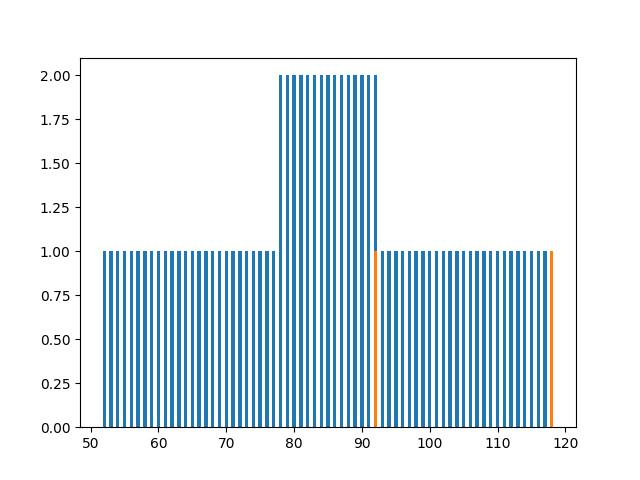

In [ ]:

t = 40


idxs = lmm.swap_indices[1][t,:t+1]#(lmm.swap_indices[1][:,:,:] + lmm.swap_indices[0][:,None, None])#[:,0]
single_idx = lmm.swap_indices[1][t,t]
ids, exposure = np.unique(idxs, return_counts=True)
single_idx_y = [1,1]
print(ids)
xs = np.arange(len(exposure))
plt.clf()
plt.bar(ids, exposure, width=0.5)
plt.bar(single_idx, single_idx_y, width=0.5)
#plt.bar()
plt.show()


In [ ]:
from joblib import Parallel, delayed

n_jobs = 4  # uses all available CPU cores
n_sims = 1000

# results = Parallel(n_jobs=n_jobs)(
#     delayed(single_run)(seed) for seed in range(n_sims))
# del lmm
# del results

In [ ]:
delta_vec = np.array([-0.6,0.3,  0.9, -0.2, 0.1])

def exponential_kernel(center_idx, vector_len, lam=1.0):
    """Generate an exponential decay kernel centered at `center_idx`."""
    indices = np.arange(vector_len)
    distances = np.abs(indices - center_idx)
    weights = np.exp(-lam * distances)
    return weights

def compute_local_delta(delta_vec, hedge_idx, lam=1.0):
    """Compute the kernel-weighted local delta around a hedgeable point."""
    kernel = exponential_kernel(center_idx=hedge_idx, vector_len=len(delta_vec), lam=lam)
    print(kernel)
    return np.dot(kernel, delta_vec)


def compute_hedge_bound(delta_vec, hedge_idx, hedge_instrument_delta=1.0, lam=1.0, alpha=1.0, epsilon=1e-4):
    """
    Compute the hedge bound, which defines how much of the instrument should be used to neutralize local delta risk.
    Returns the min and max hedge size.
    """
    local_delta = compute_local_delta(delta_vec, hedge_idx, lam)
    hedge_bound = - (alpha * local_delta) / hedge_instrument_delta

    # To support both positive and negative hedges (based on direction of local delta)
    action_low = 0
    action_high = hedge_bound

    # Ensure consistency: low < high
    if action_high < action_low:
        action_low, action_high = action_high, action_low

    return action_low, action_high, local_delta
lam = 0
hedge_max, hedge_minm, local_delta = compute_hedge_bound(delta_vec, hedge_idx=3, hedge_instrument_delta=1.0, lam=lam, alpha=1.0, epsilon=1e-4)

print("unhedged delta weighted",local_delta)
print("unhedged delta unweighted", np.sum(delta_vec))
print("unhedged delta vec unweighted", delta_vec)
delta_vec[3] += hedge_max
delta_vec
_,_,hedged_delta = compute_hedge_bound(delta_vec, hedge_idx=3, hedge_instrument_delta=1.0, lam=lam, alpha=1.0, epsilon=1e-4)

print("hedged delta weighted",hedged_delta)

print("hedged delta unweighted", np.sum(delta_vec))
print("hedged delta vec unweighted", delta_vec)

[1. 1. 1. 1. 1.]
unhedged delta weighted 0.5000000000000001
unhedged delta unweighted 0.5000000000000001
unhedged delta vec unweighted [-0.6  0.3  0.9 -0.2  0.1]
[1. 1. 1. 1. 1.]
hedged delta weighted -8.326672684688674e-17
hedged delta unweighted -8.326672684688674e-17
hedged delta vec unweighted [-0.6  0.3  0.9 -0.7  0.1]


In [ ]:
# import utils.py
import environment.utils as utils
import environment.Trading as trading
import environment.Environment as env
# reload import 
from importlib import reload

reload(utils)
reload(trading)
reload(env)

util = utils.Utils(lmm.swap_sim_shape[0],t=lmm.t_to_idx(1)
                   , np_seed=42, num_sim = lmm.swap_sim_shape[1])
util#.convert_tensor_to_option_objects(hedge_swaption, liab=True)
util.init_market_data(hedge_swaption, liab_swaption, hedge_swap, liab_swap)
pf = trading.MainPortfolio(util)
class Temp:
    pass
result = Temp()
pf.reset(0)
pf.step(0.5,-1., 1., 1, result)
from absl import flags
FLAGS = flags.FLAGS
try:
    FLAGS.vega_obs
    # Use the flag value in your code
    print("Vega observation is enabled.")
except:
    flags.DEFINE_boolean('vega_obs', False, 'Include portfolio vega and hedging option vega in state variables (Default False)')
FLAGS([''])  # Manually parse with empty args (required if not already parsed)

# Manually override the flag value
FLAGS.vega_obs = True

pf.get_state(1)
trenv = env.TradingEnv(utils=util)
trenv.reset()
for i in range(3):
    print("REWARD")
    print(trenv.step(np.array([0.5,-1., 1.]))[1]) # TODO: find ud af om vi får de rigtige resultater
#util.num_period 
#utils.Utils(lmm.swap_hedge_expiry_idx, np_seed=42, num_sim = lmm.swap_sim.shape[1]).agg_poisson_dist(np.ones_like(results[0][0]), np.ones_like(results[0][0]))

reward 0.00012207700757369924
Vega observation is enabled.
REWARD
reward -0.0024942969324798225
-0.0024942969324798225
REWARD
reward -0.0010541153825831828
-0.0010541153825831828
REWARD
reward -0.0020536411495543695
-0.0020536411495543695


In [ ]:
# lowest price for each episode per expiry across all time steps

hedge_swap[...,0].min(axis=0).min(axis=0)

array([-0.001 , -0.0002, -0.0001, -0.    ,  0.    ])

(53, 1)


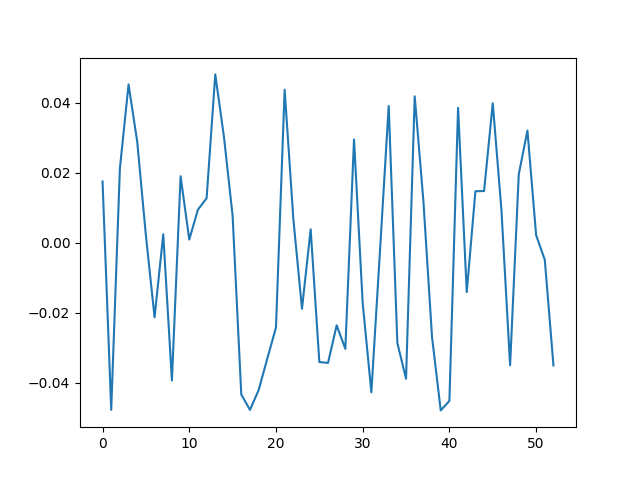

In [ ]:
import tensorflow as tf
import numpy as np
embed = tf.keras.layers.Embedding(input_dim=53, output_dim=1)
embed_arr = np.zeros((53, 1))
for i in range(53):
    embed_arr[i] = embed(tf.constant(i))
import matplotlib.pyplot as plt
print(embed_arr.shape)
plt.clf()
plt.plot(np.sum(embed_arr, axis=1))

plt.show()

# clear plot

In [ ]:

n_swaps = np.arange(2)
forward_offsets = np.arange(2) * 2
col_indices = n_swaps[:, None] + forward_offsets[None, :]
col_indices

array([[0, 2],
       [1, 3]])